# Keypoint Estimation EDA

In [1]:
import os
import sys
import git
import json
import pprint
import cv2
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import lightning as L

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

sys.path.append(f"{git_root}/keypoint_estimation/")
from datamodule import KeypointEstDataModule

dataset_dir = os.path.join(os.path.expanduser("~"), "Documents/datasets")

# print table configs
pl.Config.restore_defaults()
pl.Config.set_tbl_cols(-1)
# pl.Config.set_tbl_rows(1)

polars.config.Config

## Ego4D dataset

In [3]:
ann_dir = os.path.join(dataset_dir, "ego4d/v2/annotations/")

# load manifest data
manifest_path = os.path.join(ann_dir, "manifest.csv")
df_manifest = pl.read_csv(manifest_path)

# load annotation data
train_ann_path = os.path.join(ann_dir, "fho_oscc-pnr_train.json")
val_ann_path = os.path.join(ann_dir, "fho_oscc-pnr_val.json")
test_ann_path = os.path.join(ann_dir, "fho_oscc-pnr_test_unannotated.json")

def load_json_as_df(path):
    return pl.read_ndjson(
        bytes("\n".join(
            [json.dumps(r) for r in json.load(open(path, 'r'))["clips"]]
        ), 'utf-8')
    )

df_train = load_json_as_df(train_ann_path)
df_val = load_json_as_df(val_ann_path)
df_test = load_json_as_df(test_ann_path)

### Meta data analysis

In [4]:
def print_df(df):
    print(
        f"shape: {df.shape}",
        f"schema:\n{pprint.pformat(df.schema)}",
        sep="\n",
        end="\n\n"
    )

print_df(df_manifest)
print_df(df_train)
print_df(df_val)
print_df(df_test)

shape: (9611, 45)
schema:
{'benchmarks': Utf8,
 'canonical_audio_base_denominator': Float64,
 'canonical_audio_base_numerator': Float64,
 'canonical_audio_channel_layout': Utf8,
 'canonical_audio_channel_rate_hz': Float64,
 'canonical_audio_duration_pts': Float64,
 'canonical_audio_duration_sec': Float64,
 'canonical_audio_start_pts': Float64,
 'canonical_audio_start_sec': Float64,
 'canonical_display_height': Int64,
 'canonical_display_width': Int64,
 'canonical_fps': Float64,
 'canonical_is_validated': Boolean,
 'canonical_mp4_duration_sec': Float64,
 'canonical_num_frames': Int64,
 'canonical_s3_location': Utf8,
 'canonical_video_base_denominator': Int64,
 'canonical_video_base_numerator': Int64,
 'canonical_video_duration_pts': Int64,
 'canonical_video_duration_sec': Float64,
 'canonical_video_start_pts': Int64,
 'canonical_video_start_sec': Float64,
 'deid_scrubbed_audio': Boolean,
 'deid_scrubbed_faces': Boolean,
 'device': Utf8,
 'display_resolution_height': Int64,
 'display_res

shape: (1, 2)
┌──────────┬──────────┐
│ positive ┆ negative │
│ ---      ┆ ---      │
│ u32      ┆ u32      │
╞══════════╪══════════╡
│ 74905    ┆ 21044    │
└──────────┴──────────┘


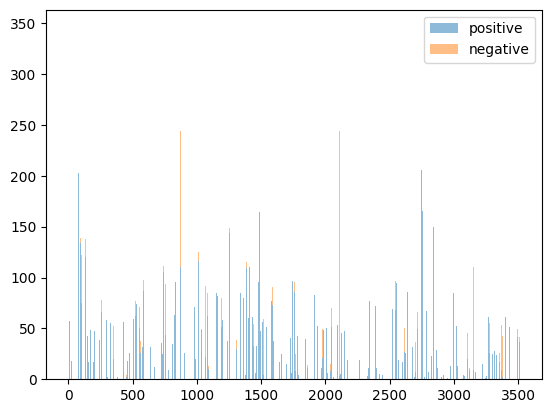

shape: (1, 2)
┌──────────┬──────────┐
│ positive ┆ negative │
│ ---      ┆ ---      │
│ u32      ┆ u32      │
╞══════════╪══════════╡
│ 38621    ┆ 14720    │
└──────────┴──────────┘


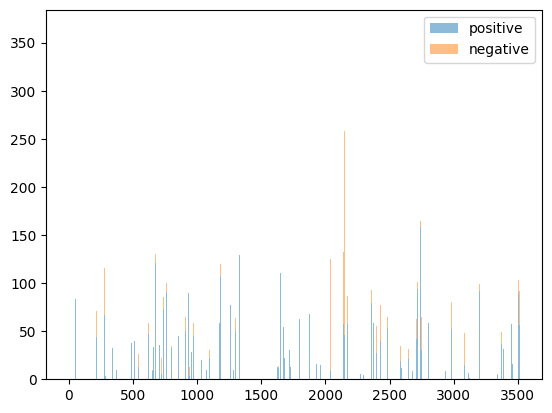

In [6]:
# state change presence
def get_state_chg_count(df):
    return df.select(
        pl.col("clip_id"),
        pl.col("state_change").count().over("clip_id").alias("clip_num"),
        pl.col("state_change").where(
            pl.col("state_change") == True
        ).count().over("clip_id").alias("positive"),
        pl.col("state_change").where(
            pl.col("state_change") == False
        ).count().over("clip_id").alias("negative"),
    ).unique()

# train data
state_chg_train = get_state_chg_count(df_train)

print(
    state_chg_train.select(
        pl.col("positive").sum(),
        pl.col("negative").sum(),
    )
)

plt.hist(
    state_chg_train.select(
        pl.col("clip_id").cast(pl.Int32),
        pl.col("clip_id").cast(pl.Int32).alias("clip_id2"),
    ),
    weights=state_chg_train.select(
        pl.col("positive"),
        pl.col("negative"),
    ),
    stacked=True,
    bins=5000,
    alpha=0.5,
    label=["positive", "negative"]
)

plt.legend()
plt.show()

# validation data
state_chg_val = get_state_chg_count(df_val)

print(
    state_chg_val.select(
        pl.col("positive").sum(),
        pl.col("negative").sum(),
    )
)

plt.hist(
    state_chg_val.select(
        pl.col("clip_id").cast(pl.Int32),
        pl.col("clip_id").cast(pl.Int32).alias("clip_id2"),
    ),
    weights=state_chg_val.select(
        pl.col("positive"),
        pl.col("negative"),
    ),
    stacked=True,
    bins=5000,
    alpha=0.5,
    label=["positive", "negative"]
)

plt.legend()
plt.show()

plt.clf()
plt.close()

shape: (9, 3)
┌────────────┬────────────────┬────────────────────┐
│ describe   ┆ clip_pnr_frame ┆ clip_pnr_frame_val │
│ ---        ┆ ---            ┆ ---                │
│ str        ┆ f64            ┆ f64                │
╞════════════╪════════════════╪════════════════════╡
│ count      ┆ 74905.0        ┆ 38621.0            │
│ null_count ┆ 0.0            ┆ 0.0                │
│ mean       ┆ 0.48625        ┆ 0.421546           │
│ std        ┆ 0.117063       ┆ 0.13543            │
│ min        ┆ 0.004167       ┆ 0.0                │
│ 25%        ┆ 0.4625         ┆ 0.367647           │
│ 50%        ┆ 0.495833       ┆ 0.429293           │
│ 75%        ┆ 0.529167       ┆ 0.481928           │
│ max        ┆ 0.991667       ┆ 1.0                │
└────────────┴────────────────┴────────────────────┘


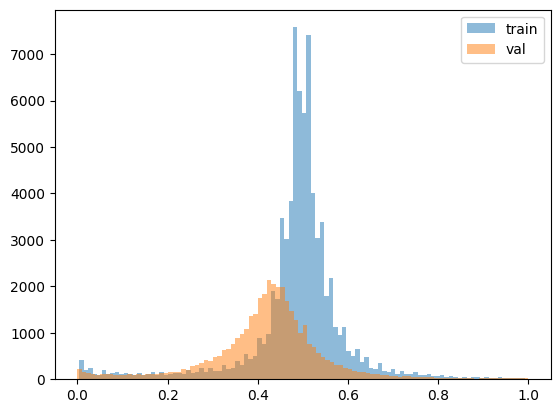

In [7]:
# temporal location of PNR frames (on clip level)
def get_pnr_loc_clip(df):
    return df.select(
        (
            (pl.col("clip_pnr_frame") - pl.col("clip_start_frame")) /\
            (pl.col("clip_end_frame") - pl.col("clip_start_frame"))
        ).where(pl.col("state_change") == True)
    )

pnr_loc_train_clip = get_pnr_loc_clip(df_train)
pnr_loc_val_clip = get_pnr_loc_clip(df_val)

print(
    pnr_loc_train_clip.describe().join(
        pnr_loc_val_clip.describe(),
        on="describe",
        suffix="_val",
    )
)

plt.hist(pnr_loc_train_clip, bins=100, alpha=0.5, label="train")
plt.hist(pnr_loc_val_clip, bins=100, alpha=0.5, label="val")

plt.legend()
plt.show()

plt.clf()
plt.close()

shape: (9, 3)
┌────────────┬──────────────────┬──────────────────────┐
│ describe   ┆ parent_pnr_frame ┆ parent_pnr_frame_val │
│ ---        ┆ ---              ┆ ---                  │
│ str        ┆ f64              ┆ f64                  │
╞════════════╪══════════════════╪══════════════════════╡
│ count      ┆ 74905.0          ┆ 38621.0              │
│ null_count ┆ 0.0              ┆ 0.0                  │
│ mean       ┆ 0.494457         ┆ 0.502876             │
│ std        ┆ 0.291065         ┆ 0.274427             │
│ min        ┆ 0.000772         ┆ 0.000615             │
│ 25%        ┆ 0.232618         ┆ 0.273112             │
│ 50%        ┆ 0.486056         ┆ 0.506598             │
│ 75%        ┆ 0.746691         ┆ 0.729109             │
│ max        ┆ 0.99928          ┆ 0.999276             │
└────────────┴──────────────────┴──────────────────────┘


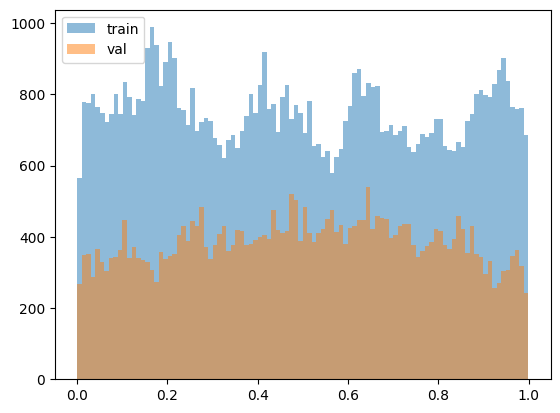

In [8]:
# temporal location of PNR frames (on video level)
def get_pnr_loc_video(df, df_manifest):
    return df.join(
        df_manifest,
        on="video_uid",
    ).select(
        (
            pl.col("parent_pnr_frame") / pl.col("canonical_num_frames")
        ).where(pl.col("state_change") == True)
    )

pnr_loc_train_video = get_pnr_loc_video(df_train, df_manifest)
pnr_loc_val_video = get_pnr_loc_video(df_val, df_manifest)

print(
    pnr_loc_train_video.describe().join(
        pnr_loc_val_video.describe(),
        on="describe",
        suffix="_val",
    )
)

plt.hist(pnr_loc_train_video, bins=100, alpha=0.5, label="train")
plt.hist(pnr_loc_val_video, bins=100, alpha=0.5, label="val")

plt.legend()
plt.show()

plt.clf()
plt.close()

In [9]:
# temporal interval between PNR frames (on video level)
def get_pnr_intvl_video(df, df_manifest):
    return df.join(
        df_manifest,
        on="video_uid",
    ).select(
        "video_uid", "parent_pnr_frame",
    ).drop_nulls().groupby(
        "video_uid",
    ).agg(
        "parent_pnr_frame",
    ).with_columns(
        pl.struct(
            ["parent_pnr_frame"],
        ).apply(
            lambda c: np.diff(sorted(c["parent_pnr_frame"])).tolist(),
        ).alias("diff"),
    ).explode(
        "diff"
    ).filter(
        # same pnr is recorded with different clip_id
        # ignoring diff=0 to get accurate mean
        pl.col("diff") > 0
    ).select("diff")

pnr_intvl_train_video = get_pnr_intvl_video(df_train, df_manifest)
pnr_intvl_val_video = get_pnr_intvl_video(df_val, df_manifest)

print(
    df_train.join(
        df_manifest,
        on="video_uid",
    ).select(
        "video_uid", "parent_pnr_frame",
    ).drop_nulls().groupby(
        "video_uid",
    ).agg(
        "parent_pnr_frame",
    ).with_columns(
        pl.struct(
            ["parent_pnr_frame"],
        ).apply(
            lambda c: np.diff(sorted(c["parent_pnr_frame"])).tolist(),
        ).alias("diff"),
    ).filter(
        pl.col("video_uid") == "8e58a7b3-43ef-406d-ad5d-901f83418261"
    ).rows()
)

print(
    df_val.join(
        df_manifest,
        on="video_uid",
    ).select(
        "video_uid", "parent_pnr_frame",
    ).drop_nulls().groupby(
        "video_uid",
    ).agg(
        "parent_pnr_frame",
    ).with_columns(
        pl.struct(
            ["parent_pnr_frame"],
        ).apply(
            lambda c: np.array(c["parent_pnr_frame"])[np.argwhere(
                np.diff(sorted(c["parent_pnr_frame"])) == 1
            )].flatten().tolist(),
        ).alias("diff_1_frame"),
    ).explode("diff_1_frame").drop_nulls().rows()[0]
)

print(
    pnr_intvl_train_video.describe().join(
        pnr_intvl_val_video.describe(),
        on="describe",
        suffix="_val",
    )
)

[('8e58a7b3-43ef-406d-ad5d-901f83418261', [63116, 63498, 63538, 63887, 63956, 64124, 64167, 64167, 64192, 64207, 64225, 64299, 64307, 64324, 64340, 64392, 64514, 64553, 64937, 65204, 65231, 65296, 65889, 65925, 65937, 65953, 65973, 66052, 66289, 66377, 66427, 66507, 66720, 66715, 66777, 66867, 66950, 67203, 67227, 67274, 67427, 67501, 67946, 68038, 68063, 68268, 68282, 68315, 68408, 68577, 69023, 69126, 69180, 69228, 69278, 69500, 69552, 69800, 69850, 70156, 70206, 70412, 70517, 70553, 70801, 70907, 70948, 71000, 71299, 71390, 71416, 71487, 71525, 71645, 71731, 71773, 71940, 198090, 198357, 198619, 198793, 198823, 198849, 198893, 199065, 199095, 199115, 199142, 199154, 199220, 199264, 199345, 199491, 200224, 200265, 200295, 200363, 200560, 200606, 200697, 201090, 201119, 201128, 201168, 201210, 201266, 201396, 201448, 201610, 202223, 202247, 202395, 202424, 202487, 202512, 202536, 202575, 202606, 202654, 202709, 202888, 202907, 202920, 203119, 203163, 203188, 203237, 203445, 203467, 20

## Ego4d dataset with reorganization

### Dataset analysis

In [27]:
L.seed_everything(42, workers=True)

datamodule = KeypointEstDataModule(
    dataset_dir=dataset_dir,
    dataset_mode="ego4d",
    batch_size=1,
    transform_mode="display",
    selection="segsec",
    sample_num=16,
    seg_arg=8,
    neg_ratio=None,
    with_info=True,
    fast_load=True,
)
datamodule.setup()
train_dataset = datamodule.train_data
val_dataset = datamodule.val_data

datamodule.setup(stage="test")
test_dataset = datamodule.test_data

Global seed set to 42


Creating video level information ...
Creating segments ...
Creating samples ...


shape: (9, 4)
┌────────────┬──────────────────┬──────────────────────┬───────────────────────┐
│ describe   ┆ parent_pnr_frame ┆ parent_pnr_frame_val ┆ parent_pnr_frame_test │
│ ---        ┆ ---              ┆ ---                  ┆ ---                   │
│ str        ┆ f64              ┆ f64                  ┆ f64                   │
╞════════════╪══════════════════╪══════════════════════╪═══════════════════════╡
│ count      ┆ 77916.0          ┆ 23022.0              ┆ 12455.0               │
│ null_count ┆ 0.0              ┆ 0.0                  ┆ 0.0                   │
│ mean       ┆ 0.500181         ┆ 0.503489             ┆ 0.500549              │
│ std        ┆ 0.290116         ┆ 0.290351             ┆ 0.289649              │
│ min        ┆ 0.0              ┆ 0.0                  ┆ 0.0                   │
│ 25%        ┆ 0.251046         ┆ 0.251046             ┆ 0.246862              │
│ 50%        ┆ 0.502092         ┆ 0.506276             ┆ 0.502092              │
│ 75%        ┆

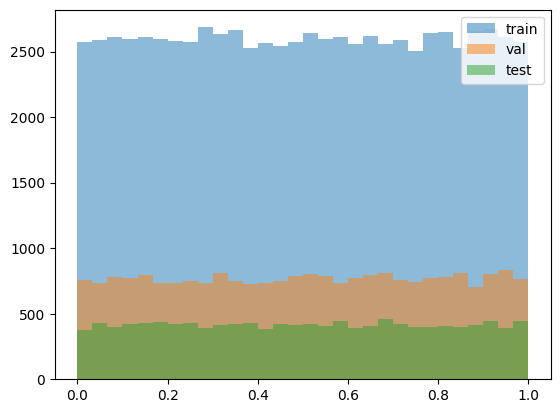

In [28]:
# temporal location of PNR frames (on segment level)
def get_pnr_loc_seg(df):
    return df.explode(
        "parent_pnr_frame"
    ).filter(
        pl.col("parent_pnr_frame").is_not_null() == True
    ).select(
        (pl.col("parent_pnr_frame") - pl.col("segment_start_frame")) /\
        (pl.col("segment_end_frame") - pl.col("segment_start_frame"))
    )

pnr_loc_train_seg = get_pnr_loc_seg(train_dataset.ann_df)
pnr_loc_val_seg = get_pnr_loc_seg(val_dataset.ann_df)
pnr_loc_test_seg = get_pnr_loc_seg(test_dataset.ann_df)

print(
    pnr_loc_train_seg.describe().join(
        pnr_loc_val_seg.describe(),
        on="describe",
        suffix="_val",
    ).join(
        pnr_loc_test_seg.describe(),
        on="describe",
        suffix="_test",
    )
)

plt.hist(pnr_loc_train_seg, bins=30, alpha=0.5, label="train")
plt.hist(pnr_loc_val_seg, bins=30, alpha=0.5, label="val")
plt.hist(pnr_loc_test_seg, bins=30, alpha=0.5, label="test")

plt.legend()
plt.show()

### Sample analysis

In [29]:
# number of state_changes in sets
print(
    train_dataset.ann_df.groupby("state_change").agg(pl.count()).join(
        val_dataset.ann_df.groupby("state_change").agg(pl.count()),
        on="state_change",
        suffix="_val",
    ).join(
        test_dataset.ann_df.groupby("state_change").agg(pl.count()),
        on="state_change",
        suffix="_test",
    )
)

# number of keyframes for positive samples
with pl.Config(tbl_rows=-1):
    print(
        train_dataset.ann_df.groupby(pl.col("hard_label").list.sum())\
        .agg(pl.count()).sort("hard_label").join(
            val_dataset.ann_df.groupby(pl.col("hard_label").list.sum())\
            .agg(pl.count()).sort("hard_label"),
            on="hard_label",
            suffix="_val",
            how="outer",
        ).join(
            test_dataset.ann_df.groupby(pl.col("hard_label").list.sum())\
            .agg(pl.count()).sort("hard_label"),
            on="hard_label",
            suffix="_test",
            how="outer",
        )
    )

shape: (2, 4)
┌──────────────┬───────┬───────────┬────────────┐
│ state_change ┆ count ┆ count_val ┆ count_test │
│ ---          ┆ ---   ┆ ---       ┆ ---        │
│ bool         ┆ u32   ┆ u32       ┆ u32        │
╞══════════════╪═══════╪═══════════╪════════════╡
│ false        ┆ 23390 ┆ 7549      ┆ 4825       │
│ true         ┆ 31637 ┆ 9634      ┆ 5113       │
└──────────────┴───────┴───────────┴────────────┘
shape: (15, 4)
┌────────────┬───────┬───────────┬────────────┐
│ hard_label ┆ count ┆ count_val ┆ count_test │
│ ---        ┆ ---   ┆ ---       ┆ ---        │
│ i64        ┆ u32   ┆ u32       ┆ u32        │
╞════════════╪═══════╪═══════════╪════════════╡
│ 0          ┆ 23390 ┆ 7549      ┆ 4825       │
│ 1          ┆ 11727 ┆ 3795      ┆ 1885       │
│ 2          ┆ 8697  ┆ 2696      ┆ 1465       │
│ 3          ┆ 5284  ┆ 1517      ┆ 870        │
│ 4          ┆ 3013  ┆ 835       ┆ 444        │
│ 5          ┆ 1622  ┆ 435       ┆ 252        │
│ 6          ┆ 720   ┆ 179       ┆ 108     

### Single data analysis

In [42]:
L.seed_everything(42, workers=True)

# load dataloader
iter_counter = 0
datamodule.setup()
# datamodule.setup(stage="test")
# dataloader = iter(datamodule.train_dataloader())
dataloader = iter(datamodule.val_dataloader())
# dataloader = iter(datamodule.test_dataloader())

Global seed set to 42


iter counter: 4
vid: f7aec252-bd4f-4696-8de5-ef7b871e2194 from 10561 to 10800 
frames shape: torch.Size([1, 16, 3, 224, 224])
pnr frames: [tensor([10727]), tensor([10746]), tensor([10726]), tensor([10777]), tensor([10793])]
converted frames shape: (16, 224, 224, 3)
labels: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]])
binary label: tensor([[1]])


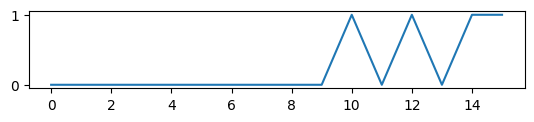

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


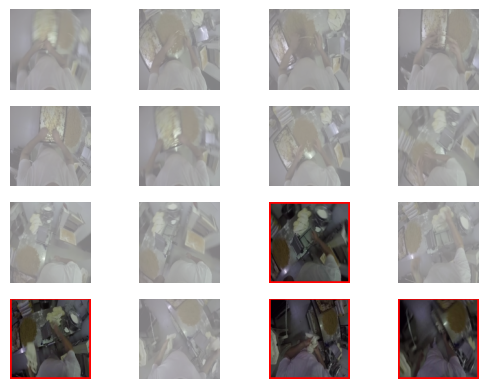

In [46]:
# frames, labels, metalabel, info = next(dataloader)
# iter_counter += 1

while True:
    frames, labels, metalabel, info = next(dataloader)
    iter_counter += 1
    if labels.max(dim=1, keepdims=True).values > 0:
        break

# convert torch.Size([b, frame_num, ch, w, h])
# to torch.Size([frame_num, w, h, ch])
# and to numpy array with type uint8
imgs = frames.permute(0,1,3,4,2).detach().numpy().copy()[0]

print(
    f"iter counter: {iter_counter}",
    (
        f"vid: {info['video_uid'][0]} " + \
        f"from {int(info['segment_start_frame'])} " + \
        f"to {int(info['segment_end_frame'])} "
    ),
    f"frames shape: {frames.shape}",
    f"pnr frames: {info['parent_pnr_frame']}",
    f"converted frames shape: {imgs.shape}",
    f"labels: {labels}",
    f"binary label: {labels.max(dim=1, keepdims=True).values}",
    sep="\n",
)

def add_pnr_annotation(frames, labels):
    ann_idx = np.where(labels == 1)[1]
    for i in ann_idx:
        w, h, _ = frames[i].shape
        frames[i] = cv2.rectangle(frames[i], (0,0), (w,h), (255,0,0), 5)
    return frames

# visualize labels
fig = plt.figure()
plt.plot(
    np.arange(len(info["sample_frames"])),
    labels.detach().numpy().copy()[0],
)
fig.set_figheight(1)

plt.show()

# visualize images as gif
import matplotlib.animation as animation
fig = plt.figure()
plots = [[plt.imshow(i)] for i in add_pnr_annotation(imgs, labels)]
ani = animation.ArtistAnimation(fig, plots, interval=750)
ani.save('anim.gif')

from IPython import display
html = display.HTML(ani.to_jshtml())
display.display(html)
plt.close()

# visualize images as image grid
fig = plt.figure()
for i in range(len(imgs)):
    ax = fig.add_subplot(4, 4, 1+i)
    ax.axis("off")
    img = imgs[i]

    # add transparency
    w, h, _ = img.shape
    alpha = np.full((w,h,1), labels[0][i] * 0.5 + 0.5)
    img = np.dstack([img, alpha])

    # add red surrounding box
    # cv2.rectangle does not support image with (w,h,c,a)
    if labels[0][i] == 1:
        thickness = 5
        img[:thickness, :, :] = (1,0,0,1)
        img[-thickness:, :, :] = (1,0,0,1)
        img[:, :thickness, :] = (1,0,0,1)
        img[:, -thickness:, :] = (1,0,0,1)

    plt.imshow(img)

plt.show()

plt.clf()
plt.close()